### Import the needed package

In [1]:
import sys
sys.path.insert(0, '../')

import os
import utilities as utils
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

load_dotenv()

c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

True

### Global variables

In [2]:
path_full = os.environ.get("ORI_PATH")
path_dataset_train = os.path.join(path_full, "datasets", "splitted", "original", "train")
batch_size = 16

### Get the batched dataset

In [3]:
train_img, train_mask = utils.load_img_mask(path_dataset_train)

In [4]:
trainset = utils.create_dataset(train_img, train_mask, batch_size=batch_size)

### Visualized the image

background px: 16046
disc px: 228
cup px: 110


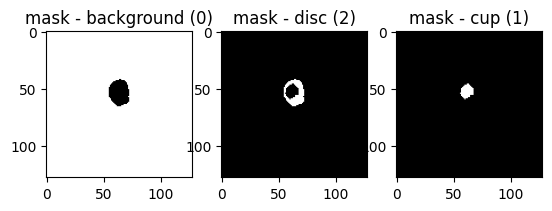

In [5]:
for imgs, masks in trainset.take(1):
    for mask in masks:
        print(f"background px: {np.sum(mask[:,:,0])}",
            f"disc px: {np.sum(mask[:,:,2])}",
            f"cup px: {np.sum(mask[:,:,1])}",
            sep='\n')
        plt.subplot(1,3,1)
        plt.title("mask - background (0)")
        plt.imshow(mask[:,:,0], cmap='gray')
        plt.subplot(1,3,2)
        plt.title("mask - disc (2)")
        plt.imshow(mask[:,:,2], cmap='gray')
        plt.subplot(1,3,3)
        plt.title("mask - cup (1)")
        plt.imshow(mask[:,:,1], cmap='gray')
        plt.show()
        break

### Calculate the weights - method 1

In [6]:
px_count = {0: [], 1: [], 2: []}
for imgs, masks in trainset.take(batch_size):
    for mask in masks:
        for i in range(3):
            px_count[i].append(np.sum(mask[:,:,i]))

In [7]:
weights = {0: [], 1: [], 2: []}
for label, pxs in px_count.items():
    for index in range(len(pxs)):
        weights[label].append((1 / pxs[index]) * (np.sum([px_count[0][index],
                                                            px_count[1][index],
                                                            px_count[2][index]]) / 3))

In [8]:
avg_weights = {}
for label, w in weights.items():
    avg_weights[label] = round(np.mean(w), 4)

print(avg_weights)

{0: 0.3392, 1: 90.8128, 2: 32.1602}


### Calculate the weights - methods 2

In [9]:
final = {0: [], 1: [], 2: []}
for imgs, masks in trainset.take(batch_size):
    for mask in masks:
        count_px = {}
        for i in range(3):
            count_px[i] = np.sum(mask[:,:,i])
        for i in range(3):
            final[i].append((1 / count_px[i]) * (np.sum([count_px[0], count_px[1], count_px[2]]) / 3))

In [10]:
for label, pxs in final.items():
    final[label] = round(np.mean(pxs), 4)
print(final)

{0: 0.3392, 1: 90.8128, 2: 32.1602}


### Calculate weight - method 3 (for image segmentation)

In [ ]:
label = np.array([0, 1, 2])
prediction = np.array([[0.1, 0.2, 0.7],
                        [0.3, 0.3, 0.4],
                        [0.5, 0.3, 0.2]])
sample_weight = np.array(list(final.values()))

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE
)
loss(label, prediction, sample_weight).numpy()

array([  0.46400849, 102.89714668,  39.87321488])

In [18]:
class_weights = tf.constant(list(final.values()))
class_weights = class_weights / tf.reduce_sum(class_weights)
class_weights.numpy()

array([0.00275074, 0.73644619, 0.26080307])

In [ ]:
def add_sample_weights(img:tf.Tensor, mask:tf.Tensor, class_weights:dict):
    class_weights = tf.constant(list(class_weights.values()))
    class_weights = class_weights / tf.reduce_sum(class_weights)
    sample_weights = tf.gather(class_weights, indices=tf.cast(mask, tf.int32))
    print(sample_weights)
    return img, mask, sample_weights

In [29]:
trainset.map(lambda img, mask: add_sample_weights(img, mask, final))

Tensor("GatherV2:0", shape=(None, 128, 128, 3), dtype=float32)


<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>